In [1]:
# import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns 
import html
from bs4 import BeautifulSoup
import requests
import os
from selenium import webdriver
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings; warnings.simplefilter('ignore')
from VE_scraper_functions import *
from chromedriver_py import binary_path # this will get you the path variable
from selenium.webdriver.common.by import By
import time
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel.Lang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# import dataset
path = "park_scrape_content_dataset.xlsx"
park_scrape_dataset2 = pd.read_excel(path)
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page                                            content website location  park
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
3               3      3  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
4               4      4  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
...           ...    ...                                              

In [3]:
## convert all text to lowercase to avoid case sensitivity issues
park_scrape_dataset2['content'] = park_scrape_dataset2['content'].str.lower()
## remove harpers ferry
park_scrape_dataset2['content'] = park_scrape_dataset2['content'].str.replace('harpers ferry', '')
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page                                            content website location  park
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
3               3      3  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
4               4      4  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
...           ...    ...                                              

In [4]:
pt_words =  [
       " bus ", "shuttle", "transit", "public transportation", "ferry", "ferry service", "subway", "train", "metro"]

In [5]:
def count_pt_words(text):
    word_counts = {word: text.lower().count(word) for word in pt_words}
    return word_counts
word_counts_df = park_scrape_dataset2['content'].apply(count_pt_words).apply(pd.Series)
word_counts_df['total'] = word_counts_df.sum(axis=1)
word_counts_df.head()

,bus,shuttle,transit,public transportation,ferry,ferry service,subway,train,metro,total
0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,1


In [6]:
park_scrape_dataset2 = pd.concat([park_scrape_dataset2, word_counts_df], axis=1)
park_scrape_dataset2 = park_scrape_dataset2.drop("content", axis="columns")
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page website location  park   bus   shuttle  transit  public transportation  ferry  ferry service  subway  train  metro  total
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI      0        0        0                      1      0              0       0      0      0      1
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI      0        0        0                      1      0              0       0      0      0      1
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI      0        0        0                      1      0              0       0      0      0      1
3               3      3  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI      0        0        0                      1      0              0       0  

In [7]:
park_scrape_dataset2.to_csv("PTbypage.csv")
park_scrape_dataset2.to_csv(r"C:\Users\Daniel.Lang\DOT OST\volpe-proj-VU16A100 - Emerging Mobility\Subgroup Support\Traveler Information Technologies\Enhancing Trip Planning Information\AnalysisResults\PTbypage.csv")

In [8]:
path = "clusterlookup.csv"
clusters = pd.read_csv(path)
clusters.head

<bound method NDFrame.head of     Park Alpha                                      NPS Full Name Region  FinalCluster                    Label
0         ABLI  Abraham Lincoln Birthplace National Historical...    SER             8    Rural High Visitation
1         ACAD                               Acadia National Park    NER             1            Transit Parks
2         ADAM                     Adams National Historical Park    NER             1            Transit Parks
3         AFBG            African Burial Ground National Monument    NER             2              Urban Sites
4         AGFO                Agate Fossil Beds National Monument    MWR             7     Rural Low Visitation
..         ...                                                ...    ...           ...                      ...
383       WWIM                               World War I Memorial    NCR             2              Urban Sites
384       YELL                          Yellowstone National Park    IMR  

In [9]:
park_word_counts = park_scrape_dataset2.groupby('park')[pt_words].sum()
park_word_counts['total'] = park_word_counts.sum(axis=1)
park_word_counts.head

<bound method NDFrame.head of        bus   shuttle  transit  public transportation  ferry  ferry service  subway  train  metro  total
park                                                                                                   
ABLI      0        0        0                      6      0              0       0      2      0      8
ACAD     26       15        1                      5     12              1       0     10      0     70
ADAM      0        1        0                     21      0              0      21     14      1     58
AFBG      0        0        5                     14      0              0       8      5      1     33
AGFO      0        0        0                     14      0              0       0      4      0     18
...     ...      ...      ...                    ...    ...            ...     ...    ...    ...    ...
YELL      9       11        6                      9      0              0       0     32      0     67
YOSE      9       32        3     

In [10]:
clustersubset = clusters[['Park Alpha', "FinalCluster", "Label"]]
clustersubset.rename(columns={'Park Alpha':"park"}, inplace = True)
clusterparks = pd.merge(park_word_counts, clustersubset, on="park", how="left")
clusterparks['ferrynet'] = clusterparks['ferry'] - clusterparks['ferry service']
clusterparks.head

<bound method NDFrame.head of      park   bus   shuttle  transit  public transportation  ferry  ferry service  subway  train  metro  total  FinalCluster                    Label  ferrynet
0    ABLI      0        0        0                      6      0              0       0      2      0      8           8.0    Rural High Visitation         0
1    ACAD     26       15        1                      5     12              1       0     10      0     70           1.0            Transit Parks        11
2    ADAM      0        1        0                     21      0              0      21     14      1     58           1.0            Transit Parks         0
3    AFBG      0        0        5                     14      0              0       8      5      1     33           2.0              Urban Sites         0
4    AGFO      0        0        0                     14      0              0       0      4      0     18           7.0     Rural Low Visitation         0
..    ...    ...      

In [11]:
clusterparks.to_csv("ptbypark.csv")
clusterparks.to_csv(r"C:\Users\Daniel.Lang\DOT OST\volpe-proj-VU16A100 - Emerging Mobility\Subgroup Support\Traveler Information Technologies\Enhancing Trip Planning Information\AnalysisResults\PTbypark.csv")

In [12]:
total_parks_counts = clusterparks.groupby('Label').size().reset_index(name='Total_Parks')
total_parks_counts['Total_Parks'] = total_parks_counts['Total_Parks'].astype(int) 
filtered_df = clusterparks[clusterparks['total'] > 1]
ev_parks_counts = filtered_df.groupby('Label').size().reset_index(name='pt_Parks')
label_counts = pd.merge(total_parks_counts, ev_parks_counts, on='Label', how='left')
label_counts['pt_Parks'].fillna(0, inplace=True)
label_counts['Percent_pt'] = round((label_counts['pt_Parks'] / label_counts['Total_Parks']) * 100, 1)
label_counts['pt_Parks'] = label_counts['pt_Parks'].astype(int)
label_counts.head()

,Label,Total_Parks,pt_Parks,Percent_pt
0,High Seasonal Variation,42,36,85.7
1,Low Visitation Sites,19,17,89.5
2,Rural High Visitation,63,57,90.5
3,Rural Low Visitation,72,62,86.1
4,Transit Parks,49,49,100.0


In [13]:
total_row = label_counts.sum(numeric_only=True)
total_row['Label'] = 'Total'
total_counts = label_counts.append(total_row, ignore_index=True)
total_counts['pt_Parks'] = total_counts['pt_Parks'].astype(int)
total_counts['Total_Parks'] = total_counts['Total_Parks'].astype(int)
total_counts.loc[total_counts['Label'] == 'Total', 'Percent_pt'] = round((total_counts.loc[total_counts['Label'] == 'Total', 'pt_Parks'] / total_counts.loc[total_counts['Label'] == 'Total', 'Total_Parks']) * 100, 1)
total_counts.tail()

,Label,Total_Parks,pt_Parks,Percent_pt
4,Transit Parks,49,49,100.0
5,Urban High Visitation,34,32,94.1
6,Urban Low Visitation,66,57,86.4
7,Urban Sites,38,34,89.5
8,Total,383,344,89.8


In [14]:
total_counts.to_csv("ptbycluster.csv")

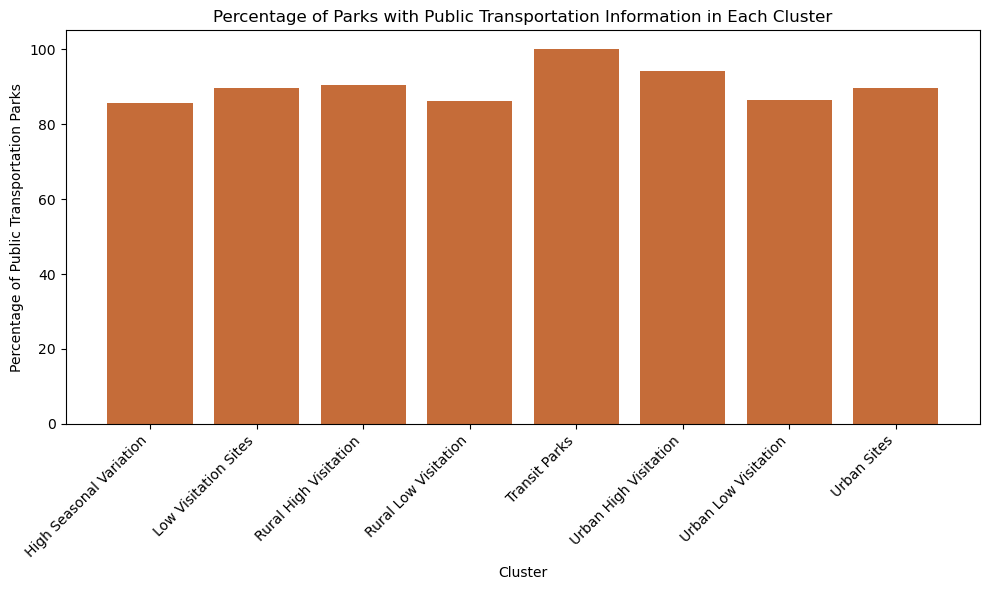

In [15]:
plt.figure(figsize=(10, 6)) 
plt.bar(label_counts['Label'], label_counts['Percent_pt'], color='#C56C39')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Public Transportation Parks')
plt.title('Percentage of Parks with Public Transportation Information in Each Cluster')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

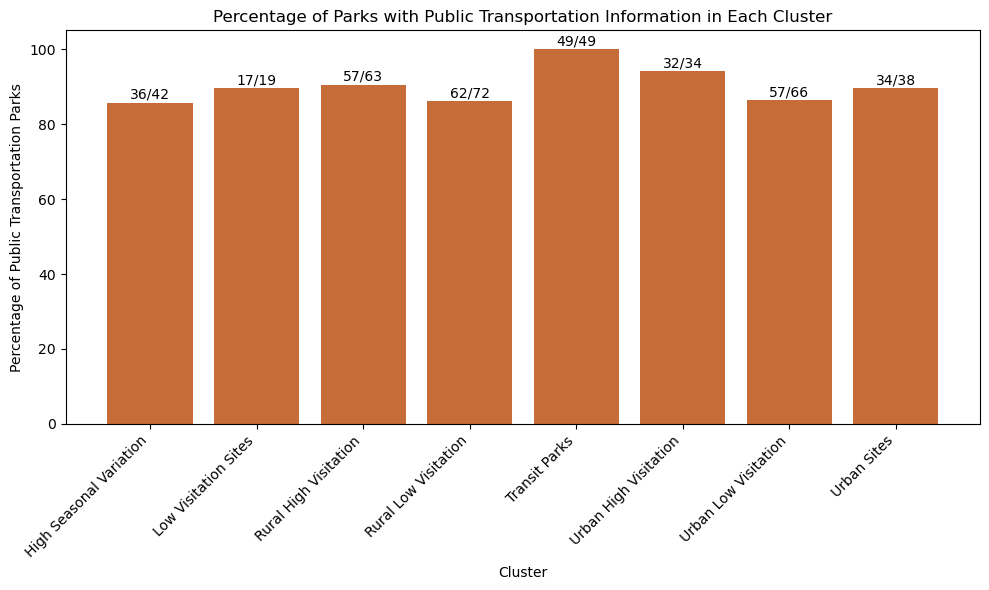

In [16]:
plt.figure(figsize=(10, 6)) 
bars = plt.bar(label_counts['Label'], label_counts['Percent_pt'], color='#C56C39')

for i, bar in enumerate(bars):
    pt_parks = label_counts['pt_Parks'].iloc[i]
    total_parks = label_counts['Total_Parks'].iloc[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.25,
             f"{pt_parks}/{total_parks}",
             ha='center', va='bottom')
    
##avg_percent_ev = label_counts['Percent_EV'].mean()
##plt.axhline(y=avg_percent_ev, color='red', linestyle='--')

plt.xlabel('Cluster')
plt.ylabel('Percentage of Public Transportation Parks')
plt.title('Percentage of Parks with Public Transportation Information in Each Cluster')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig("ptGraph.png")
plt.show()

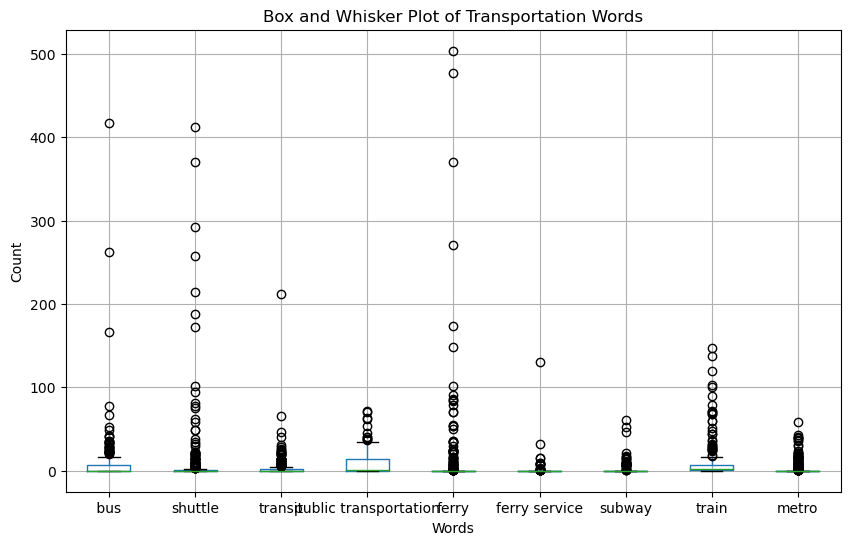

In [17]:
averages = {word: park_word_counts[word].mean() for word in pt_words}
plt.figure(figsize=(10, 6))
park_word_counts.boxplot(column=pt_words)
plt.title('Box and Whisker Plot of Transportation Words')
plt.ylabel('Count')
plt.xlabel('Words')
plt.show()

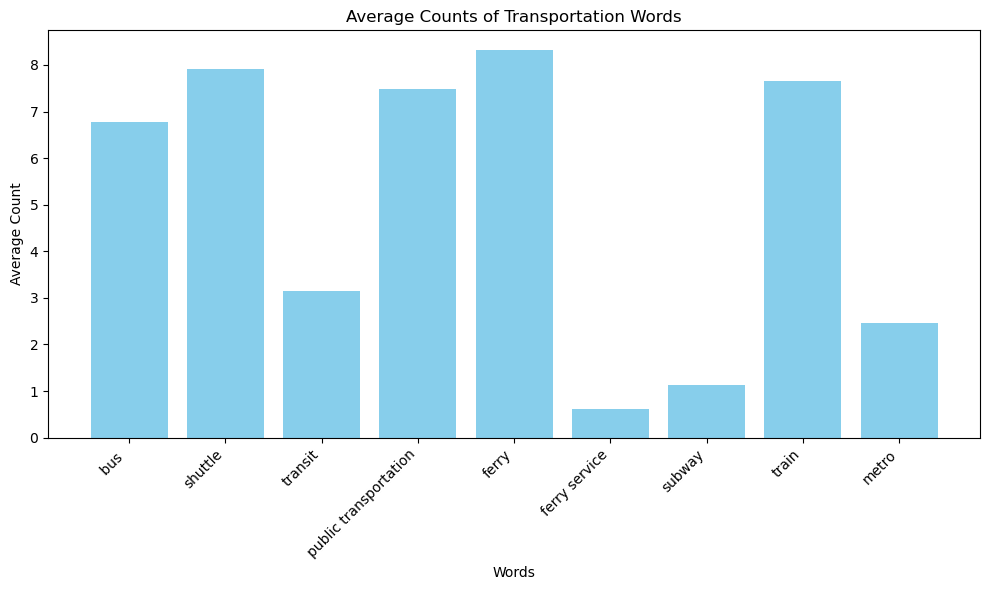

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(averages.keys(), averages.values(), color='skyblue')
plt.title('Average Counts of Transportation Words')
plt.xlabel('Words')
plt.ylabel('Average Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()